# VIDEOtag Dataset의 Annotation에서 Bbox 추가하는 과정

In [10]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import utils
import model as modellib
from model import log
import coco
import visualize
import json
from pycocotools import mask as maskUtils
from skimage.measure import find_contours
from skimage.measure import approximate_polygon
from skimage.measure import moments
import cv2
                            
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = "/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/images"
JSON_ALL_DIR = "/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/result_instances.json"
JSON_BBOX_DIR = "/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/result_instances_with_bbox.json"

COCO_CATEGORY_JSON = "assets/json/coco_categories.json"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


# Create Model & Load Weight

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

# Prepare COCO categories

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Prepare VIDEOtag, COCO category 맵핑 데이타

In [5]:
# Load VIDEOtag, COCO category 맵핑 데이타
map_data = open("assets/json/category.json").read()
tmp_videotag_coco_cate_map = json.loads(map_data)["categories"]

# dictionary로 생성
videotag_coco_cate_map = {}
for cate_data in tmp_videotag_coco_cate_map:
    videotag_coco_cate_map[cate_data['id']] = cate_data

# Prepare VIDEOtag Dataset

### 0101~0102 dataset
https://s3.ap-northeast-2.amazonaws.com/f-machine-learning-dataset/datasets/fingerplus/0101_0102.zip

In [8]:
print(videotag_imgs[1]['id'])
print(videotag_img_anno_ids[videotag_imgs[1]['id']])

199606
['297282', '297283']


# Detect & Extract Region

annotations : [{
  area,         // Number - 영역 넓이(w*h)
  bbox,         // [x,y,width,height], (Array(4))
  category_id,  // int
  id,           // int
  image_id,     // int
  iscrowd,      // 0 or 1 (get anns for given crowd label (False or True))
  segmentation  // Array - mask 데이터 (RLE or [polygon])
}

In [13]:
json_data = open("/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/instances.json").read()
data = json.loads(json_data)

# COCO cartgory 추가
coco_category_json = open(COCO_CATEGORY_JSON).read()
coco_category_data = json.loads(coco_category_json)

coco_cate = coco_category_data['categories']

videotag_anno = data['annotations']
videotag_imgs = data['images']
videotag_cate = data['categories']+coco_cate


videotag_img_anno_ids = {}
videotag_anno_dic = {}
videotag_cate_dic = {}


for anno in videotag_anno:
    videotag_anno_dic[anno['id']] = anno
    
for cate in videotag_cate:
    videotag_cate_dic[str(cate['id'])] = cate
    
# print(videotag_cate_dic)
    
for image in videotag_imgs:
    anno_ids = []
    image_id = image['id']
    
    for anno in videotag_anno:
        anno_img_id = anno['image_id']
        anno_id = anno['id']
        if anno_img_id == image_id:
            anno_ids.append(anno_id)
    # if not len(annos) == 0:
    videotag_img_anno_ids[image_id] = anno_ids
    
    
    
def getAnnosByIds(anno_ids):
    result = []
    for anno_id in anno_ids:  
        result.append(videotag_anno_dic[anno_id])
        
    return result

def getCategoryNameById(cate_id):
    vt_cate_data = videotag_cate_dic[str(cate_id)]
    return vt_cate_data['name']


def getCocoCategoryIdByIdx(cate_idx):
    return coco_cate[int(cate_idx)]['id']

def getCocoCategoryNameByIdx(cate_idx):
    return getCategoryNameById(getCocoCategoryIdByIdx(cate_idx))

def upateAnnoWithBbox(anno_id, bbox, segmentation):
    for anno in videotag_anno:
        if anno['id'] == anno_id:
            anno['bbox'] = bbox
            anno['segmentation'] = segmentation
            return anno
            break
            
def insertAnno(anno):
    videotag_anno.append(anno)
    
    
extracted_annotations = []
START_ANNO_ID = 0


###################################################################
# 모든 이미지에 대하여 predict를 실시한다.
###################################################################
vt_img_total = len(videotag_imgs)
for vt_img_current, vt_img in enumerate(videotag_imgs): 
    
#     if vt_img_current < 60:
#         continue;
    
#     if vt_img_current > 5:
#         break;
    
    print(str(vt_img_current)+'/'+str(vt_img_total))
    img_id = vt_img['id']
    
    
    ###################################################################
    # videotag image에 등록되어 있느 annotation이 있는지 확인 후, 로드
    ###################################################################
    vt_annos = getAnnosByIds(videotag_img_anno_ids[img_id])
    
    if len(vt_annos) == 0:
        continue
    
    
    ###################################################################
    # videotag image이 로드
    ###################################################################
    img_path = os.path.join(IMAGE_DIR, vt_img['file_name']) 
    image = skimage.io.imread(img_path)
    # If grayscale. Convert to RGB for consistency.
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
        
    height, width = image.shape[:2]    
        
    
    ###################################################################
    # Run detection
    ###################################################################
    coco_results = model.detect([image], verbose=0)

    # Result
    r = coco_results[0]
    
    coco_result_rois = r['rois'] # y1, x1, y2, x2
    coco_result_scores = r['scores']
    coco_result_masks = r['masks'] # (height, width, 검출된 데이타 갯수)
    coco_result_class_idxs = r['class_ids']
    
    
    # 확인용
    confirm_matching_classes = []
    confirm_vt_anno_points = []
                
    is_found = 0
    
    ###################################################################
    # 추출된 Annotation을 VIDEOtag Annotation과 비교
    ###################################################################
    for index, score in enumerate(coco_result_scores):
        
        category_idx = int(coco_result_class_idxs[index])
        category_id = getCocoCategoryIdByIdx(category_idx)
#         category_name = class_names[category_id]
        category_name = getCategoryNameById(category_id)
        roi = coco_result_rois[index]
        bbox = [int(roi[1]), int(roi[0]), int(roi[3] - roi[1]), int(roi[2] - roi[0])]
        mask = coco_result_masks[:, :, index]
        
        '''
        contours
        '''
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
#         contours = find_contours(padded_mask, 0.5)
        contours = find_contours(padded_mask, 0)
        np_contours = np.array(contours)
        np_contours = np_contours[0]
        print('np_contours', np_contours.shape, np_contours)
        segmentation = approximate_polygon(np_contours, tolerance=2.5)
        segmentation = [segmentation.flatten().tolist()]
#         print('추출된 Anno', category_name, score)
        
        seg = maskUtils.encode(np.asfortranarray(mask))
        area = maskUtils.area(seg)
        
        annotation = {}
        annotation['bbox'] = bbox 
        annotation['category_id'] = str(category_idx)
        annotation['id'] = 'new_'+str(START_ANNO_ID)
        annotation['image_id'] = img_id
        annotation['iscrowd'] = 0
        annotation['area'] = int(area)
        annotation['segmentation'] = segmentation
    
        '''
        point - 물체의 중심점 추출
        '''
        mu = cv2.moments(mask)
        point_x = (mu['m10']/mu['m00'])/width
        point_y = (mu['m01']/mu['m00'])/height
        
        annotation['x_pos'] = point_x
        annotation['y_pos'] = point_y
        START_ANNO_ID += 1
        
        
        ###################################################################
        # coco model에서 검출된 annotation들이 videotag annotation(정답)들과 비교하여
        # 일치할 경우가 있을 때, 해당 videotag annotation에 bbox정보를 추가한다.
        ###################################################################
        for vt_anno in vt_annos:
            vt_anno_id = vt_anno['id']
            vt_cate_id = vt_anno['category_id']
            vt_cate_name = getCategoryNameById(vt_cate_id)
            
            vt_point_x = (width*vt_anno['x_pos'])
            vt_point_y = (height*vt_anno['y_pos'])
            
            
            coco_cate_ids = videotag_coco_cate_map[vt_cate_id]['coco_ids']
            if len(coco_cate_ids) == 0:
                continue
                
            # NOTE: 포인트가 마스크 영역에 속하는 확인
            if mask[int(vt_point_y)][int(vt_point_x)] == 0:
                continue
            
            for coco_cate_id in coco_cate_ids:
                if coco_cate_id == category_id:
                    print('찾았다', 'videotag : '+vt_cate_name, 'coco : '+category_name)
                    saved_anno = upateAnnoWithBbox(vt_anno_id, bbox, segmentation)
                    if saved_anno:
                        extracted_annotations.append(saved_anno)
                        
                    confirm_vt_anno_points.append([vt_point_y-5, vt_point_x-5, vt_point_y+5, vt_point_x+5])
                    confirm_matching_classes.append([category_name, vt_cate_name])
                    is_found = 1
                    break
                    
        ###################################################################
        # 높은 score로 검출되었으나, VIDEOtag Dataset에는 없는 데이타는 Annotations에 추가한다
        # VIDEOtag Category에는 없을 시, 추가
        ###################################################################
        if is_found == 0 and score > 0.9:
            insertAnno(annotation)
            extracted_annotations.append(annotation)
            is_found = 1
            
            # NOTE : 확인용 데이타
            cal_point_x = point_x*width
            cal_point_y = point_y*height
            confirm_vt_anno_points.append([cal_point_y-5, cal_point_x-5, cal_point_y+5, cal_point_x+5])
            confirm_matching_classes.append([category_name, category_name])
            
            print('추가', img_id, category_name, score, annotation)
            
        is_found = 0
                    
#     if not len(confirm_matching_classes) == 0:
#         print('매칭된 카테고리 확인 - ', confirm_matching_classes, confirm_vt_anno_points, img_path)
#         visualize.display_instances(image, coco_result_rois, coco_result_masks, coco_result_class_idxs, class_names, coco_result_scores, confirm_vt_anno_points)
    print('----------------------------------------------------------------------')
        
        
result_all = {}
result_all['annotations'] = videotag_anno
result_all['images'] = videotag_imgs
result_all['categories'] = videotag_cate

with open(JSON_ALL_DIR, 'w') as outfile:
    json.dump(result_all, outfile)

result_anno = {}
result_anno['annotations'] = extracted_annotations

with open(JSON_BBOX_DIR, 'w') as outfile:
    json.dump(result_anno, outfile)
    
print("done")

0/1081
1/1081
np_contours (1270, 2) [[354. 460.]
 [354. 459.]
 [354. 458.]
 ...
 [352. 461.]
 [353. 461.]
 [354. 460.]]
추가 199606 person 0.9999666 {'bbox': [46, 50, 432, 303], 'category_id': '1', 'id': 'new_0', 'image_id': '199606', 'iscrowd': 0, 'area': 63499, 'segmentation': [[354.0, 460.0, 354.0, 58.0, 348.0, 57.0, 346.0, 46.0, 314.0, 46.0, 309.0, 58.0, 280.0, 77.0, 203.0, 93.0, 191.0, 100.0, 191.0, 117.0, 204.0, 134.0, 244.0, 147.0, 249.0, 158.0, 245.0, 179.0, 224.0, 214.0, 205.0, 223.0, 158.0, 205.0, 142.0, 203.0, 108.0, 214.0, 88.0, 216.0, 71.0, 236.0, 68.0, 272.0, 76.0, 299.0, 85.0, 308.0, 110.0, 321.0, 168.0, 324.0, 188.0, 317.0, 208.0, 324.0, 222.0, 342.0, 237.0, 387.0, 269.0, 431.0, 285.0, 445.0, 303.0, 450.0, 316.0, 460.0, 337.0, 465.0, 354.0, 460.0]], 'x_pos': 0.39602589706137103, 'y_pos': 0.7088430963917192}
----------------------------------------------------------------------
2/1081


KeyboardInterrupt: 

### 저장된 데이타를 확인합니다.

(35, 2)
(360, 640)
getCocoCategoryNameByIdx 1
getCocoCategoryIdByIdx 1
1 person 29312-d9445060-ee40-11e7-bbcd-afbd708e5bbe.jpg


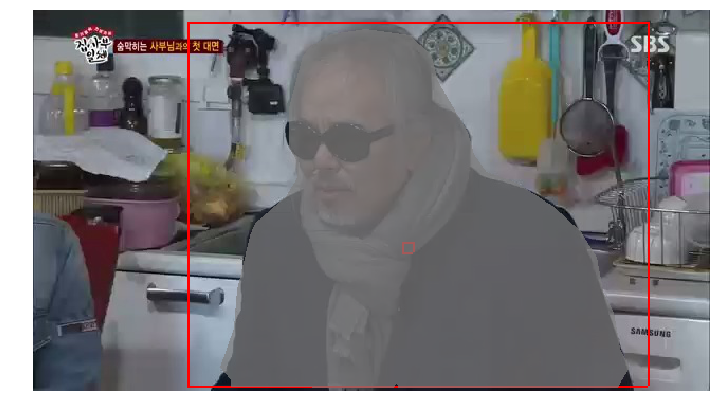

done


In [175]:
import json
import os
import skimage.io
import visualize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
# from matplotlib.path import Path
from PIL import Image, ImageDraw
import cv2
# from matplotlib.path import Path
# from matplotlib.nxutils import points_inside_poly

# array 출력 시 생략하지 않고, 모두 출력.
np.set_printoptions(threshold=np.nan)

ROOT_DIR = os.getcwd()

result_json_data = open(JSON_ALL_DIR).read()
# result_json_data = open(JSON_BBOX_DIR).read()
result_data = json.loads(result_json_data)

result_videotag_annos = result_data['annotations']
result_videotag_imgs = result_data['images']
result_videotag_cate = data['categories']

result_videotag_imgs_dic = {}

for vt_img in result_videotag_imgs:
    img_id = vt_img['id']
    result_videotag_imgs_dic[img_id] = vt_img

    
for anno in result_videotag_annos:
    
    if 'bbox' in anno:
        vt_img = result_videotag_imgs_dic[anno['image_id']]
        
        img_path = os.path.join(ROOT_DIR, '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/images', vt_img['file_name']) 
        image = skimage.io.imread(img_path)
        
        height, width = image.shape[:2]    
        
        point_x = int(width*anno['x_pos'])
        point_y = int(height*anno['y_pos'])
        
        bbox_x1 = anno['bbox'][0]
        bbox_y1 = anno['bbox'][1]
        bbox_x2 = bbox_x1+anno['bbox'][2]
        bbox_y2 = bbox_y1+anno['bbox'][3]
        
        
        # 외곽라인 그리기
        # Mask
        color = (0.5, 0.5, 0.5, 1)
        contours = anno['segmentation']
        contours = np.reshape(contours, (-1, 2)).astype(int)
        new_contours = contours.copy()
        new_contours[:,1] = contours[:,0]
        new_contours[:,0] = contours[:,1]
        
        print(contours.shape)
        
        # extract mask (0,1과 이루어진 array)
        mask = np.zeros([height,width,1],dtype=np.uint8)
        mask.fill(0)
        cv2.drawContours(mask, [new_contours], 0, (1), -1)
        mask = np.reshape(mask, (height,width))
        print(mask.shape)
        
        category_idx = anno['category_id']
        
        print(anno['category_id'], getCocoCategoryNameByIdx(category_idx), vt_img['file_name'])
        
        image = visualize.draw_box(image, [bbox_y1, bbox_x1, bbox_y2, bbox_x2], [255,0,0])
        image = visualize.draw_box(image, [point_y-5, point_x-5, point_y+5, point_x+5], [255,0,0])
        image = visualize.apply_mask(image, mask, color, alpha=0.7)
        
        
        plt.figure(figsize=(14, 14 * height // width))
        plt.axis('off')
        plt.imshow(image)
        plt.show()
        break
        
print('done')
        